<a href="https://colab.research.google.com/github/Sreerag-ibtl/tutorial/blob/master/image_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
mkdir '/content/data' 

In [0]:
rm -rf ann ann.zip img img.zip

In [0]:
!pip install imgaug

    100% |████████████████████████████████| 634kB 21.9MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug


In [0]:
cd /content/data

/content/data


In [0]:
from google.colab import files
files.upload() 

Saving img.zip to img.zip


In [0]:
import zipfile
zipobject=zipfile.ZipFile('/content/data/img.zip')
zipobject.extractall() 

In [0]:
from google.colab import files
files.upload()

Saving ann.zip to ann.zip


{'ann.zip': b'PK\x03\x04\x14\x00\x00\x00\x00\x00R\x82\\M\x95\xdf\xd5\xcf*\x00\x00\x00*\x00\x00\x00\x10\x00\x00\x00ann/109CD13.json{"tag": "train", "description": "109CD13"}PK\x03\x04\x14\x00\x00\x00\x00\x00O\x82\\M\xda\xa6\x81\xe1*\x00\x00\x00*\x00\x00\x00\x10\x00\x00\x00ann/14CE754.json{"tag": "train", "description": "14CE754"}PK\x03\x04\x14\x00\x00\x00\x00\x00A\x82\\M\x88h\x02D+\x00\x00\x00+\x00\x00\x00\x11\x00\x00\x00ann/29AE2141.json{"tag": "train", "description": "29AE2141"}PK\x03\x04\x14\x00\x00\x00\x00\x00C\x82\\Ma\xdf\xea\xda+\x00\x00\x00+\x00\x00\x00\x11\x00\x00\x00ann/29AQ1619.json{"tag": "train", "description": "29AQ1619"}PK\x03\x04\x14\x00\x00\x00\x00\x00@\x82\\M8\xe9\xa8\x9e$\x00\x00\x00$\x00\x00\x00\x0c\x00\x00\x00ann/2IY.json{"tag": "val", "description": "2IY"}PK\x03\x04\x14\x00\x00\x00\x00\x00P\x82\\MF@\x89\xb8\'\x00\x00\x00\'\x00\x00\x00\r\x00\x00\x00ann/7778.json{"tag": "train", "description": "7778"}PK\x03\x04\x14\x00\x00\x00\x00\x00N\x82\\M\x05F\x97\x1e)\x00\x00\x00

In [0]:
zipobject=zipfile.ZipFile('/content/data/ann.zip')
zipobject.extractall()

In [0]:
import keras
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
print('Keras version', keras.__version__)

Using TensorFlow backend.


TensorFlow version: 1.12.0-rc2
Keras version 2.1.6


In [0]:
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
import numpy as np
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
import cv2

In [0]:
sess=tf.Session()
K.set_session(sess)

In [0]:
from collections import Counter
def get_counter(dirpath,tag):
    dirname=os.path.basename(dirpath)
    ann_dirpath=join(dirpath,'ann')
    letters=''
    lens=[]
    for filename in os.listdir(ann_dirpath):
        json_filepath=join(ann_dirpath, filename)
        ann=json.load(open(json_filepath, 'r'))
        tags=ann['tag']
        if tag in tags:
            description=ann['description']
            lens.append(len(description))
            letters+=description
    print('Max plate length in "%s":'%dirname,max(Counter(lens).keys()))
    return Counter(letters)
c_val=get_counter('/content/data','val')
c_train=get_counter('/content/data','train')
letters_train=set(c_train.keys())
letters_val=set(c_val.keys())
if letters_train == letters_val:
    print('Letters in train and val do match')
else:
    raise Exception()
print(len(letters_train),len(letters_val),len(letters_val|letters_train))
letters=sorted(list(letters_train))
print('Letters:',' '.join(letters))

Max plate length in "data": 11
Max plate length in "data": 11
Letters in train and val do match
36 36 36
Letters: 0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z


In [0]:
#sometimes(iaa.ContrastNormalization((0.75,1.5))),
#sometimes(iaa.AdditiveGaussianNoise(loc=0,scale=(0.0,0.05*255),per_channel=0.5)),
#scale={"x":(0.8,1.2),"y":(0.8,1.2)},
#shear=(-8,8)
from imgaug import augmenters as iaa
sometimes=lambda aug:iaa.Sometimes(0.5,aug)
seq=iaa.SomeOf((0,3),[
    sometimes(iaa.Crop(px=(0, 16))),
    #sometimes(iaa.ContrastNormalization((0.75,1.5))),
    #iaa.Fliplr(0.5),
    #sometimes(iaa.AdditiveGaussianNoise(loc=0,scale=(0.0,0.05*255),per_channel=0.5)),
    sometimes(iaa.GaussianBlur(sigma=(0,3.0))),        
    sometimes(iaa.Affine(
        rotate=(-25,25),    
        scale={"x":(0.8,1.2),"y":(0.8,1.2)},
        #shear=(-8,8)   
    ))
],random_order=True)

In [0]:
letters.append('')
def labels_to_text(labels):
    return ''.join(list(map(lambda x:letters[int(x)],labels)))
def text_to_labels(text):
    return list(map(lambda x:letters.index(x),text))
def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True
class TextImageGenerator:    
    def __init__(self, 
                 dirpath,
                 tag,
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor,
                 max_text_len=11):        
        self.img_h=img_h
        self.img_w=img_w
        self.batch_size=batch_size
        self.max_text_len=max_text_len
        self.downsample_factor=downsample_factor   
        img_dirpath=join(dirpath, 'img')
        ann_dirpath=join(dirpath, 'ann')
        self.samples=[]
        for filename in os.listdir(img_dirpath):
            name,ext=os.path.splitext(filename)
            if ext in ['.png', '.jpg']:
                img_filepath=join(img_dirpath, filename)
                json_filepath=join(ann_dirpath,name+'.json')
                ann=json.load(open(json_filepath, 'r'))
                description=ann['description']
                tags=ann['tag']
                if tag not in tags:
                    continue
                if is_valid_str(description):
                    self.samples.append([img_filepath,description])        
        self.n=len(self.samples)
        self.indexes = list(range(self.n))
        self.cur_index = 0        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img = cv2.imread(img_filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img /= 255
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            self.imgs[i, :, :] = img
            self.texts.append(text)        
    def get_output_size(self):
        return len(letters) + 1    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if K.image_data_format() == 'channels_first':
                X_data = np.ones([self.batch_size, 1, self.img_w, self.img_h])
            else:
                X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X_data[i] = img
                lab_data = []
                lab_data = text_to_labels(text)
                if len(lab_data) < 11:
                  for k in range((11-len(lab_data))):
                    lab_data.append('36')
                Y_data[i] = lab_data
                #Y_data[i] = text_to_labels(text)
                source_str.append(text)
                label_length[i] = len(text)    
            images_aug=seq.augment_images(X_data)    
            inputs = {
                'the_input': images_aug,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                #'source_str': source_str
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [0]:
tiger = TextImageGenerator('/content/data', 'train', 128, 64, 8, 4)
tiger.build_data()

Text generator output (data which will be fed into the neutral network):
1) the_input (image)


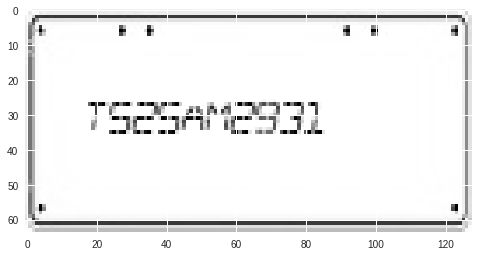

2) the_labels (plate number): TS25AM2931 is encoded as [29, 28, 2, 5, 10, 22, 2, 9, 3, 1, 36]
3) input_length (width of image that is fed to the loss function): 30 == 128 / 4 - 2
4) label_length (length of plate number): 10


In [0]:
for inp, out in tiger.next_batch():
    print('Text generator output (data which will be fed into the neutral network):')
    print('1) the_input (image)')
    if K.image_data_format() == 'channels_first':
        img = inp['the_input'][0, 0, :, :]
    else:
        img = inp['the_input'][0, :, :, 0]
    
    plt.imshow(img.T, cmap='gray')
    plt.show()
    print('2) the_labels (plate number): %s is encoded as %s' % 
          (labels_to_text(inp['the_labels'][0]), list(map(int, inp['the_labels'][0]))))
    print('3) input_length (width of image that is fed to the loss function): %d == %d / 4 - 2' % 
          (inp['input_length'][0], tiger.img_w))
    print('4) label_length (length of plate number): %d' % inp['label_length'][0])
    break

In [0]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
def train(img_w, load=False):
    img_h = 64
    conv_filters = 16
    kernel_size = (3,3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512
    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
    batch_size = 32
    downsample_factor = pool_size ** 2
    tiger_train = TextImageGenerator('/content/data', 'train', img_w, img_h, batch_size, downsample_factor)
    tiger_train.build_data()
    tiger_val = TextImageGenerator('/content/data', 'val', img_w, img_h, batch_size, downsample_factor)
    tiger_val.build_data()
    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)
    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
    inner = Dense(tiger_train.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    model = Model(inputs=input_data, outputs=y_pred).summary()
    labels = Input(name='the_labels', shape=[tiger_train.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    if load:
        model = load_model('./tmp_model.h5', compile=False)
    else:
        model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    if not load:
        model.fit_generator(generator=tiger_train.next_batch(), 
                            steps_per_epoch=tiger_train.n,
                            epochs=1, 
                            validation_data=tiger_val.next_batch(), 
                            validation_steps=tiger_val.n)
    return model

In [0]:
model = train(128, load=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [0]:
rm weights.h5

In [0]:
model.save_weights('weights.h5')

In [0]:
img_w = 128
img_h = 64
conv_filters =16
kernel_size = (3,3)
pool_size = 2
time_dense_size = 32
rnn_size = 512
if K.image_data_format() == 'channels_first':
    input_shape = (1, img_w, img_h)
else:
    input_shape = (img_w, img_h, 1)
batch_size = 32
downsample_factor = pool_size ** 2
tiger_train = TextImageGenerator('/content/data', 'train', img_w, img_h, batch_size, downsample_factor)
tiger_train.build_data()
tiger_val = TextImageGenerator('/content/data', 'val', img_w, img_h, batch_size, downsample_factor)
tiger_val.build_data()
act = 'relu'
input_data = Input(name='the_input', shape=input_shape, dtype='float32')
inner = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv1')(input_data)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
inner = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv2')(inner)
inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)
gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
inner = Dense(tiger_train.get_output_size(), kernel_initializer='he_normal',
              name='dense2')(concatenate([gru_2, gru_2b]))
y_pred = Activation('softmax', name='softmax')(inner)
Model(inputs=input_data, outputs=y_pred).summary()

labels = Input(name='the_labels', shape=[tiger_train.max_text_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
#if load:
    #model = load_model('./tmp_model.h5', compile=False)
#else:
    #model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
model.load_weights('/content/data/weights.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 128, 64, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 64, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 64, 32, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 64, 32, 16)   2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

In [0]:
model1=Model(inputs=input_data,outputs=y_pred)

In [0]:
from google.colab import files

from keras.models import load_model

uploaded = files.upload()

print(uploaded)

Using TensorFlow backend.


Saving model1_better.h5 to model1_better.h5


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
model = load_model( 'model1_better.h5' )

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
rm test1.jpeg

In [0]:
files.upload()

In [0]:
import cv2
import matplotlib.pyplot as plt
import itertools

In [0]:
import numpy as np

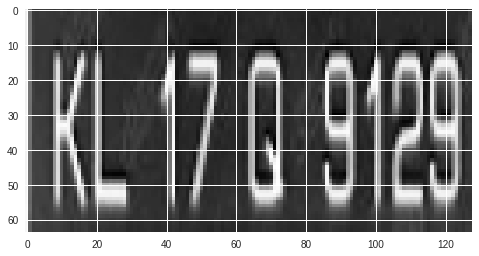

In [0]:
image=cv2.imread('test1.jpeg')
image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image=cv2.resize(image,(128, 64))
plt.imshow(image)
image=image.T
image=image.astype(np.float32)
image=image/255
image=np.expand_dims(image,-1)
image=np.expand_dims(image,0)

In [0]:
letters = [ '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z' ]

In [0]:
import itertools

In [0]:
def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

In [0]:
out=model.predict(image)
decode_batch(out)

['KL77AS4425']

In [0]:
model1.save('/root/data/model1.h5')

In [0]:
files.download('/root/data/model1.h5')